# AWS-ASDI
EDA on the NOAA Global Historical Climatology Network Daily Dataset. This dataset contains over 200 years worth of climate data, and we will analyze the dataset through the use of data science tools that are scalable (Modin, NumS, and Ray). Because the tools we use are scalable, we are able to run the same code on a laptop to a cluster of nodes. Before getting started, make sure you set `num_cpus` in `ray_init()` to the number of physical cores on the CPU running this notebook for optimal performance, otherwise Ray might automatically set it to logical cores that include hyperthreading. Additionally, for cluster setup, the only thing that needs to be changed is properly setting the correct parameters in `ray.init()` and now the same notebook should be able to scale on a distributed system.

When done with the notebook, you can properly shutdown Ray to free all processes and memory using:
```python
ray.shutdown()
```
For convenience, this cell is included at the end of the notebook.

In [1]:
local = True # Change this flag to False to download data off of s3 storage directly
n_jobs = 32 # This should be set to the number of logical cores

In [2]:
import ray
ray.init(ignore_reinit_error=True, num_cpus=n_jobs, _temp_dir="/home/brian/external/aws-asdi/ray_temp"); # Remove or reassign _temp_dir if not enough disk storage on device
#ray.init(ignore_reinit_error=True, address="auto", _redis_password='5241590000000000') #ray.init() config for cluster setup
import modin.pandas as pd
import pandas
from nums import numpy as nps
from nums.core import settings
from nums.experimental import nums_modin
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import plotly.express as px
import plotly.graph_objects as go
import os
import warnings
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import gzip
import sys
from io import StringIO
warnings.filterwarnings("ignore")

2021-08-16 23:07:42,574	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


Setting for NumS to assign head and worker nodes.

In [3]:
# NumS settings
if len(ray.nodes()) > 1:
    settings.cluster_shape = (len(ray.nodes())-1, 1)
settings.cluster_shape

(1, 1)

## Downloading the Data and File Organization
* [Data](https://registry.opendata.aws/noaa-ghcn/)
* [Documentation](https://docs.opendata.aws/noaa-ghcn-pds/readme.html)

We can use AWS CLI to speed things up by downloading it locally. More info about installation is provided [here](https://aws.amazon.com/cli/).

To view files in terminal/command line:
```sh
aws s3 ls s3://noaa-ghcn-pds/ --no-sign-request
```

To download locally (*about 100GB of free data is needed on disk*), we can download directly to our `data/` directory:
```sh
mkdir data
aws s3 cp --recursive s3://noaa-ghcn-pds/csv/ --no-sign-request data
```

If downloading will take too much storage space, we can run this notebook completely off of memory, by setting the `local` tag to `False` in the cell directly above. Some `.txt` files will be directly loaded from S3, as they are relatively small and are just lookup tables/directories for the `.csv` files.

File directory should look like this:
```
├── data/
├── figures/
├── eda.ipynb
├── README.md
└── requirements.txt
```

Here, we test downloading a `.csv` file directly from the AWS S3 bucket to memory. Ensure this is working before running the next cells. This notebook will do all of the data cleaning of DataFrames in memory. Because the S3 bucket is public, there should be no need to insert any AWS/S3 credentials.

In [4]:
%%time
climate_2020 = pd.read_csv('s3://noaa-ghcn-pds/csv/2020.csv', header=None)
climate_2020.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")
del climate_2020 # delete from memory

CPU times: user 5.35 s, sys: 3.6 s, total: 8.94 s
Wall time: 38.3 s


In [5]:
%%time
climate_2020 = pandas.read_csv('s3://noaa-ghcn-pds/csv/2020.csv', header=None)
climate_2020.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")
del climate_2020 # delete from memory

CPU times: user 23.3 s, sys: 6.05 s, total: 29.4 s
Wall time: 56.7 s


The times below are tested on a single node setup. As we can see, the speedups are not reliable as it is dependent on our connection speed between your network to the S3 bucket (located on us-east-1):

**modin**
```
CPU times: user 11.6 s, sys: 2.99 s, total: 14.6 s
Wall time: 1min 42s
```
**pandas**
```
CPU times: user 25.3 s, sys: 3.68 s, total: 29 s
Wall time: 1min 22s
```

In [6]:
%%time
#skip if not downloaded locally
climate_2020 = pd.read_csv('data/2020.csv', header=None)
climate_2020.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")
del climate_2020 # delete from memory

CPU times: user 1.48 s, sys: 683 ms, total: 2.16 s
Wall time: 3.38 s


In [7]:
%%time
#skip if not downloaded locally
climate_2020 = pandas.read_csv('data/2020.csv', header=None)
climate_2020.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")
del climate_2020 # delete from memory

CPU times: user 17.4 s, sys: 3.25 s, total: 20.6 s
Wall time: 19.9 s


We can try the same cell again, but with data already stored to the local filesystem for a more reliable benchmark. As we can see, a significant speedup for a file that is 1 GB in size:

**modin**
```
CPU times: user 1.3 s, sys: 518 ms, total: 1.82 s
Wall time: 2.92 s
```
**pandas**
```
CPU times: user 17 s, sys: 2.16 s, total: 19.2 s
Wall time: 18.7 s
```

## Global Variables and DataFrames
Some variables and DataFrames that will be useful in parsing out data.

For inventory, data is stored like this:

```
Variable	Columns	Type
ID	1-11	CHARACTER
LATITUDE	13-20	REAL
LONGITUDE	22-30	REAL
ELEMENT	32-35	CHARACTER
FIRSTYEAR	37-40	INTEGER
LASTYEAR	42-45	INTEGER
```

Sample query
```
ACW00011604  17.1167  -61.7833 TMAX 1949 1949
```

In [8]:
inventory = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-inventory.txt', widths=[12, 9, 10, 4, 5, 5], header=None)
inventory.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEMENT", "FIRSTYEAR", "LASTYEAR"]
inventory

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949
...,...,...,...,...,...,...
704607,ZI000067983,-20.2000,32.6160,PRCP,1951,2020
704608,ZI000067983,-20.2000,32.6160,TAVG,1962,2020
704609,ZI000067991,-22.2170,30.0000,TMAX,1951,1990
704610,ZI000067991,-22.2170,30.0000,TMIN,1951,1990


For stations, the data is formatted like this:
```
Variable	Columns	Type	Example
ID	1-11	Character	EI000003980
LATITUDE	13-20	Real	55.3717
LONGITUDE	22-30	Real	-7.3400
ELEVATION	32-37	Real	21.0
STATE	39-40	Character
NAME	42-71	Character	MALIN HEAD
GSN FLAG	73-75	Character	GSN
HCN/CRN FLAG	77-79	Character
WMO ID	81-85	Character	03980
```

A sample query:
```
AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196
```

In [9]:
stations = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-stations.txt', widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None)
stations.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN FLAG", "HCN/CRN FLAG", "WMO ID"]
stations

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,NaN,DUBAI INTL,NaN,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,NaN,ABU DHABI INTL,NaN,NaN,41217.0
...,...,...,...,...,...,...,...,...,...
118487,ZI000067969,-21.0500,29.3670,861.0,NaN,WEST NICHOLSON,NaN,NaN,67969.0
118488,ZI000067975,-20.0670,30.8670,1095.0,NaN,MASVINGO,NaN,NaN,67975.0
118489,ZI000067977,-21.0170,31.5830,430.0,NaN,BUFFALO RANGE,NaN,NaN,67977.0
118490,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,NaN,67983.0


In [10]:
country_codes = pd.read_csv("s3://noaa-ghcn-pds/ghcnd-countries.txt", delimiter="\n", header=None)[0].str.extract('(?P<code>.{2})(?P<country>.{0,})')
country_codes

,code,country
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan
...,...,...
214,WI,Western Sahara
215,WQ,Wake Island [United States]
216,WZ,Swaziland
217,ZA,Zambia


In [11]:
# Global variables
elements = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]
all_elements = list(inventory["ELEMENT"].unique())
years = list(range(1763, 2022))

## Utility Functions
Some helpful functions in helping with EDA and modeling

In [12]:
def df_loader(year, local=False):
    if local:
        df = pd.read_csv('data/' + str(year) + '.csv', header=None)
    else:
        object_key = 'csv/' + str(year) + '.csv'
        csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
        body = csv_obj['Body']
        csv_string = body.read().decode('utf-8')
        df = pd.read_csv(StringIO(csv_string), header=None)
    df.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
    df["YEAR/MONTH/DAY"] = pd.to_datetime(df["YEAR/MONTH/DAY"], format="%Y%m%d")
    return df

In [13]:
def df_filter(df, _id, element):
    return df.loc[(df["ID"] == _id) & (df["ELEMENT"] == element)][["YEAR/MONTH/DAY", "DATA VALUE"]].set_index("YEAR/MONTH/DAY").sort_index()

In [14]:
# Same as df_filter(), but a vector of ALL the data
def df_filter_vector(_id, element, local=False, custom_years=None):
    df_vector = pd.DataFrame(columns=["DATA VALUE"])
    if custom_years:
        years = range(custom_years[0], custom_years[1] + 1)
    for year in tqdm(years):
        if local:
            df = df_filter(dfs[year], _id, element)
        else:
            df = df_filter(df_loader(year), _id, element)
            
        if df_vector.empty:
            df_vector = df
        else:
            df_vector = df_vector.append(df)
    return df_vector

In [15]:
# Matplotlib runs on single thread, we can parallelize plotting by using Ray
@ray.remote
def plotter(df, _id, element, save=False, year=None):
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    df = df_filter(df, _id, element)
    
    if df.empty:
        tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Plotting is skipped.")
        return

    plt.figure(figsize=(20, 10))
    plt.plot(df)
    plt.title(element + " Data at " + station_name)
    plt.xlabel("Date")
    plt.ylabel("Value")
    #plt.xlim() #figure out a way to set limit of year
    plt.ylim(-100, 400)
    if save:
        directory = "figures/" + _id + "/" + element
        try:
            # Create target directory
            os.makedirs(directory)
            tqdm.write(f"Directory " + directory + " Created ")
        except FileExistsError:
            tqdm.write(f"Directory " + directory + " already exists. File " + directory + "/" + str(year) + ".png has been saved successfully.")
        
        plt.savefig(directory + "/" + str(year) + ".png")
    plt.clf()

In [16]:
def rmse(actual, expected):
    """
    Computes the root mean squared error to evaluate models/predictions. It can accept all the datatypes used
    in this notebook
    """
    if type(actual) != type(expected):
        raise TypeError("actual and expected must be the same types")
    if type(actual) == np.ndarray:
        return np.sqrt(np.mean((expected - actual) ** 2))
    elif type(actual) == type(nps.array([])):
        return nps.sqrt(nps.mean((expected - actual) ** 2)).get()
    elif type(actual) == modin.pandas.dataframe.DataFrame or type(actual) == pandas.core.frame.DataFrame:
        raise NotImplementedError
    else:
        raise TypeError

In [17]:
def design_matrix(years, elements, target=None, convert_nps=False, local=False):
    """
    Set target to your "y" predictor. If y has NaNs or missing values, we will drop the data row.
    """
    df_design = pd.DataFrame()
    
    for year in tqdm(years):
        if local:
            df = dfs[year]
        else:
            df = df_loader(year)
            

        if target[0] not in df["ELEMENT"].unique():
            continue

        df = df[df['ELEMENT'].isin(elements)]
        df = pd.pivot_table(df, index=["ID", "YEAR/MONTH/DAY"], columns="ELEMENT", values="DATA VALUE").reset_index(level=[0,1])
        df = df.merge(stations[["ID", "LATITUDE", "LONGITUDE", "ELEVATION"]], how='inner', on='ID')
        
        if target:
            df = df.dropna(subset=target)
        df = df.dropna() #TODO add a flag to toggle this
        
        
        df["YEAR/MONTH/DAY"] = df["YEAR/MONTH/DAY"].apply(lambda x: pd.Period(x, freq='D').day_of_year)
        df["TMAX"] = df["TMAX"] / 10
        df["TMIN"] = df["TMIN"] / 10
        df["AVG"] = (df["TMAX"] + df["TMIN"]) / 2
        df["RANGE"] = df["TMAX"] - df["TMIN"]
        #df = df.drop(["ID"], axis=1)
        #df = df.astype(float)
        
        if df_design.empty:
            df_design = df
        else:
            df_design = df_design.append(df)
        
        
    
    if convert_nps:
        return nps.array(result.to_numpy().astype(np.double))
    return df_design

In [18]:
def design_matrix_time_series_stack(_id, element, years, convert_nps=True, local=False):
    """
    Inputs are station ID and element
    Output is a design matrix of time series per year stacked on top of each other.
    rows are year of data collected, 
    cols are day of the year
    
    returns NumS array or Pandas DataFrame
    """
    df_design = pd.DataFrame(columns=pd.date_range(start="2020-01-01", end="2020-12-31").strftime('%m-%d'))
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    
    for year in tqdm(years):
        if local:
            df = dfs[year]
        else:
            try:
                df = df_loader(year)
            except ClientError:
                tqdm.write(str(year) + ".csv doesn't exist on remote, addition to design matrix is skipped.")
                continue
            
        df = df_filter(df, _id, element)
        if df.empty:
            tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Addition to design matrix is skipped.")
            continue
        df.index = df.index.strftime('%m-%d')
        df.columns = [year]
        df = df.T
        df_design = df_design.append(df)


    df_design.index.name = None
    if convert_nps:
        #return nums_modin.from_modin(df_design) # Experimental version has some bugs, use manual conversion for now
        return nps.array(df_design.to_numpy().astype(np.double))
    return df_design

## Loading all the DataFrames to Memory
We can also store all the dataframes into memory. The benchmarks below are run on a single node system with 32 cores and 512 GB of memory. With no scaling, we can already see the performance gains Modin gives us by utilizing hardware threads and Ray.

In [19]:
%%time
dfs = [pd.DataFrame() for _ in range(2022)]
for year in tqdm(years):
    dfs[year] = df_loader(year, local=local)

  0%|          | 0/259 [00:00<?, ?it/s]

CPU times: user 3min 23s, sys: 1min 30s, total: 4min 53s
Wall time: 17min 24s


Loading all the dataframes from local storage to memory gives us these times:

**modin**:
```
CPU times: user 2min 48s, sys: 54 s, total: 3min 42s
Wall time: 5min 14s
```

**pandas**
```
CPU times: user 24min 22s, sys: 5min 39s, total: 30min 2s
Wall time: 29min 32s
```

As we can see, Modin gives us ~6x speedup, which is impressive considering that ~100GB is being transferred and loaded onto memory.

# EDA
Visualizations and understanding the data. We can plot how many data points each country has collected in their weather stations.

In [20]:
station_data_freq = pd.DataFrame()
years.reverse() # Reverse, so NaNs can be filled in to missing/old data

for year in tqdm(years):
    station_data_freq[year] = dfs[year].groupby(dfs[year]["ID"].str.slice(stop=2))["DATA VALUE"].sum()

years.reverse()
station_data_freq = station_data_freq.fillna(0).T
station_data_freq

  0%|          | 0/259 [00:00<?, ?it/s]

ID,AE,AF,AG,AJ,AL,AM,AO,AQ,AR,AS,...,UZ,VE,VM,VQ,WA,WF,WI,WQ,ZA,ZI
2021,519865.0,67168.0,3365075.0,575644.0,27366.0,528187.0,116387.0,233685.0,5736600.0,65259175.0,...,1665843.0,308660.0,1594501.0,1012654.0,777103.0,288938.0,69554.0,110031.0,1083.0,26033.0
2020,1049427.0,347809.0,6468526.0,1117900.0,149494.0,1063089.0,296152.0,620414.0,10303967.0,121229268.0,...,2944183.0,1060313.0,2830827.0,2002028.0,1310837.0,452695.0,149346.0,95449.0,7404.0,79597.0
2019,965715.0,381186.0,6352635.0,1155516.0,162282.0,1099505.0,264390.0,465857.0,8858792.0,112609962.0,...,3108996.0,540122.0,3350807.0,1938332.0,1793524.0,615150.0,135084.0,189020.0,28963.0,140548.0
2018,888756.0,274279.0,6694154.0,1174363.0,164416.0,1132851.0,208387.0,441797.0,8897612.0,120038907.0,...,2955479.0,1282236.0,2793026.0,1756558.0,1356098.0,476696.0,110540.0,98106.0,15406.0,210488.0
2017,910630.0,209730.0,6374097.0,924363.0,154446.0,998756.0,249585.0,437014.0,9310667.0,124485288.0,...,3090817.0,509367.0,2642634.0,1758009.0,1544604.0,535018.0,72900.0,122131.0,19058.0,387086.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
for index, row in tqdm(country_codes.iterrows()): 
    if row[0] in station_data_freq.T.columns:
        fig = plt.figure(figsize=(10, 10))
        ax = station_data_freq.T[row[0]].plot();
        ax.set_xlabel("Years")
        ax.set_ylabel("Number of Data Points")
        plt.savefig(("figures/datasamples/" + row[1] + ".png").replace(" ", "_"))
        plt.clf()

0it [00:00, ?it/s]

For example, this is number of data points for United States station.

![](figures/datasamples/_United_States_.png)

In [22]:
sample_points = []
for year in tqdm(years):
    sample_points.append(len(dfs[year].index))

  0%|          | 0/259 [00:00<?, ?it/s]

Note that there is a dip at the end. That is due to this dataset being collected and updated live. Thus, it includes the year 2021 (the current year making this notebook).

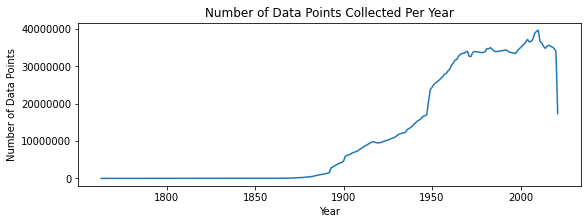

In [23]:
plt.figure(figsize=(9, 3))
plt.plot(years, sample_points);
plt.title("Number of Data Points Collected Per Year")
plt.ticklabel_format(style='plain')
plt.xlabel("Year")
plt.ylabel("Number of Data Points");

In [24]:
# Massively plots elements per year for each id
"""
for _id in tqdm(stations["ID"]):
    for element in elements:
        for year in years:
            plotter.remote(dfs[year], _id, element, save=True, year=year)
"""

'\nfor _id in tqdm(stations["ID"]):\n    for element in elements:\n        for year in years:\n            plotter.remote(dfs[year], _id, element, save=True, year=year)\n'

We can also analyze what type of weather data is being collected. Here is a plot of the top 25 weather data being collected ranked by frequency.

Text(0, 0.5, 'Count')

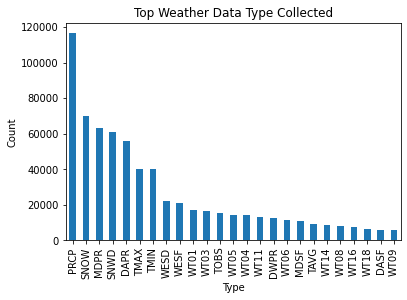

In [25]:
inventory["ELEMENT"].value_counts().head(25).plot(kind="bar");
plt.title("Top Weather Data Type Collected")
plt.xlabel("Type")
plt.ylabel("Count")

We can also analyze location of each station by plotting their longitude and latitude to give us a familiar outline:

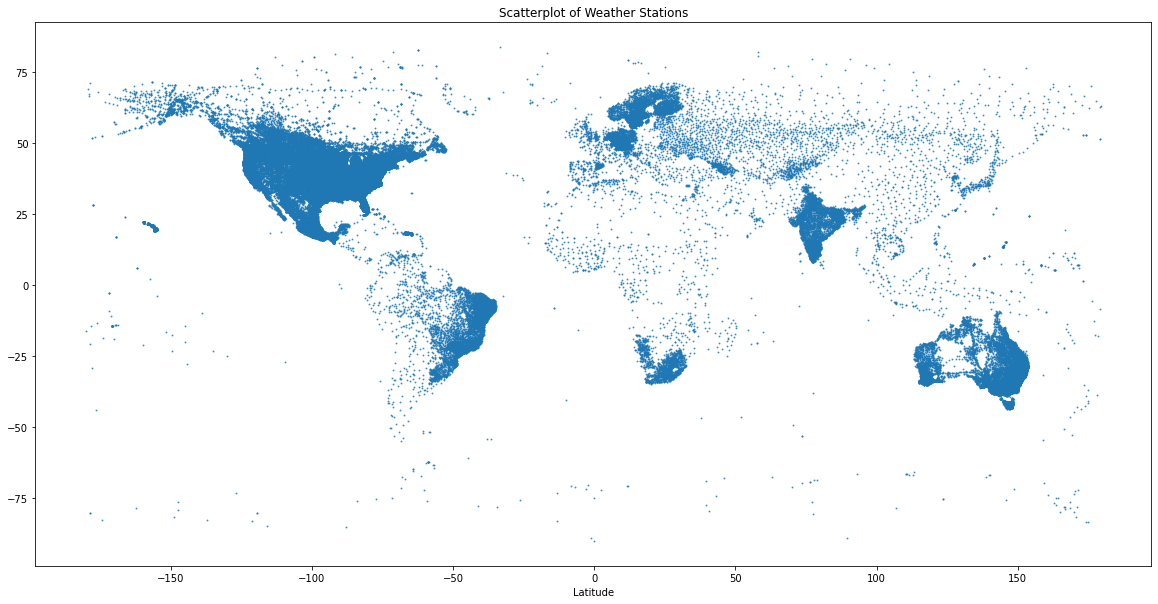

In [26]:
plt.figure(figsize=(20, 10))
plt.title("Scatterplot of Weather Stations")
plt.xlabel("Longitude")
plt.xlabel("Latitude")
plt.scatter(x=stations['LONGITUDE'], y=stations['LATITUDE'], s=0.9, alpha=0.7);

Using plotly, we can make this more interactive and visualize the density of these weather stations. Note that for some libraries that need to use Pandas, we can insert `._to_pandas()` to revert a modin dataframe to pandas. First we can plot a density heatmap to show where each station is located. It also shows us that there are more weather stations in densly populated areas.

Source/motivation: https://medium.com/plotly/how-to-create-2d-and-3d-interactive-weather-maps-in-python-and-r-77ddd53cca8

Since plotly plots can take up space, it won't be uploaded to the repo. But after running, it can be viewed through this link after it's saved to `.html` file.

Link: http://127.0.0.1:8888/files/station_density.html

(If link doesn't work, make sure port number is same. It is set to the jupyter default port 8888)

In [27]:
fig = px.density_mapbox(stations._to_pandas(), lat='LATITUDE', lon='LONGITUDE', radius=5,
                        center=dict(lat=0, lon=180), zoom=0,
                        mapbox_style="stamen-terrain")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("station_density.html")

In [28]:
df = design_matrix([2010], ["TMAX", "TMIN"], target=["TMAX"], local=True)
df["TMAX"] = df["TMAX"]
df["TMIN"] = df["TMIN"]
df

  0%|          | 0/1 [00:00<?, ?it/s]

,ID,YEAR/MONTH/DAY,TMAX,TMIN,LATITUDE,LONGITUDE,ELEVATION,AVG,RANGE
0,AE000041196,1,25.9,12.0,25.333,55.517,34.0,18.95,13.9
2,AE000041196,3,24.1,13.6,25.333,55.517,34.0,18.85,10.5
3,AE000041196,4,23.6,13.0,25.333,55.517,34.0,18.30,10.6
4,AE000041196,5,23.3,13.8,25.333,55.517,34.0,18.55,9.5
5,AE000041196,6,24.3,16.0,25.333,55.517,34.0,20.15,8.3
...,...,...,...,...,...,...,...,...,...
5966980,ZI000067983,358,33.0,19.0,-20.200,32.616,1132.0,26.00,14.0
5966981,ZI000067983,359,32.6,19.9,-20.200,32.616,1132.0,26.25,12.7
5966982,ZI000067983,361,26.6,18.0,-20.200,32.616,1132.0,22.30,8.6
5966983,ZI000067983,362,28.0,17.6,-20.200,32.616,1132.0,22.80,10.4


We can also plot the TMAX density of temperature. In addition, we can use Plotly to also plot an interactive timelapse of TMAX.

Links:
* http://127.0.0.1:8888/files/tmax_density.html
* http://127.0.0.1:8888/files/max_density_timelapse.html

In [29]:
temp = df[df["YEAR/MONTH/DAY"] == 1]._to_pandas()
fig = go.Figure(go.Densitymapbox(lat=temp.LATITUDE, lon=temp.LONGITUDE, z=temp.TMAX,
                                 radius=1))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("tmax_density.html")

In [30]:
fig = go.Figure()

# Add traces, one for each slider step
for day in tqdm(np.arange(1, 367, 1)):
    temp = df[df["YEAR/MONTH/DAY"] == day]._to_pandas()
    fig.add_trace(
        go.Densitymapbox(lat=temp.LATITUDE, lon=temp.LONGITUDE, z=temp.TMAX,
                                 radius=10, visible=False, 
                        name="Temperature Max on Day "+ str(day))
    )

# Make 10th trace visible
fig.data[0].visible = True

# Create and add slider
steps = []

for i in tqdm(range(len(fig.data))):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to Day: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    margin={"r":0,"t":0,"l":0,"b":0},
    mapbox_style="stamen-terrain", 
    mapbox_center_lon=180
)

fig.write_html("tmax_density_timelapse.html")

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

Next, let's analyze and plot data from a weather station. We will analyze the station USC00040693 in Berkeley, CA [(Google Maps)](https://www.google.com/maps/place/37°52'27.8%22N+122°15'38.2%22W/@37.8744024,-122.2618614,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d37.8744!4d-122.2606). Through Pandas/modin, we can figure out which elements of weather data this station records:

In [31]:
inventory[inventory["ID"] == 'USC00040693']

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
388869,USC00040693,37.8744,-122.2606,TMAX,1893,2021
388870,USC00040693,37.8744,-122.2606,TMIN,1893,2021
388871,USC00040693,37.8744,-122.2606,TOBS,1901,2020
388872,USC00040693,37.8744,-122.2606,PRCP,1893,2021
388873,USC00040693,37.8744,-122.2606,SNOW,1899,2010
388874,USC00040693,37.8744,-122.2606,SNWD,1913,2010
388875,USC00040693,37.8744,-122.2606,DAPR,1953,2012
388876,USC00040693,37.8744,-122.2606,MDPR,1953,2012
388877,USC00040693,37.8744,-122.2606,WT01,1893,1997
388878,USC00040693,37.8744,-122.2606,WT03,1915,1988


Data will vary a lot between stations, some stations may record as little as just precipitation. Coincidentally, this weather station is located on UC Berkeley campus and has been recording data of various elements for quite a while. The more interesting data values recorded in this station other than temperature and precipitation are the WT** data types. According to the [documentation](https://docs.opendata.aws/noaa-ghcn-pds/readme.html) they are mapped to:

* **01 = Fog, ice fog, or freezing fog (may include heavy fog)**
* 02 = Heavy fog or heaving freezing fog (not always distinguished from fog)
* **03 = Thunder**
* **04 = Ice pellets, sleet, snow pellets, or small hail**
* **05 = Hail (may include small hail)**
* 06 = Glaze or rime
* 07 = Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
* **08 = Smoke or haze**
* 09 = Blowing or drifting snow
* 10 = Tornado, waterspout, or funnel cloud
* **11 = High or damaging winds**
* 12 = Blowing spray
* 13 = Mist
* **14 = Drizzle**
* 15 = Freezing drizzl
* 16 = **Rain (may include freezing rain, drizzle, and freezing drizzle)**
* 17 = Freezing rain
* 18 = Snow, snow pellets, snow grains, or ice crystals
* 19 = Unknown source of precipitation
* 21 = Ground fog
* 22 = Ice fog or freezing fog

Unfortunately, plotting these special elements out shows us there is nothing interesting going.

In [32]:
#TODO: Make dataloading faster by batching operations into a design matrix with features, if possible. 
#Currently 7-8s per iteration, at most 12 min per vector. See if this improves when scaled.
berkeley_weather_elements = inventory[inventory["ID"] == 'USC00040693'][["ELEMENT", "FIRSTYEAR", "LASTYEAR"]]
berkeley_weather_elements = berkeley_weather_elements[berkeley_weather_elements["ELEMENT"].isin(["TMAX", "TMIN", "PRCP"])] #override to save time
berkeley_time_series = {}

for _, rows in berkeley_weather_elements.iterrows():
    element, firstyear, lastyear = rows
    berkeley_time_series[element] = df_filter_vector('USC00040693', element, local=local, custom_years=(lastyear-20, lastyear - 1)) #only grabbing the last 20 years for effiency

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

We can plot data in the last 3 years, (plotting all of the data will take a long time due to the bottleneck of matplotlib).

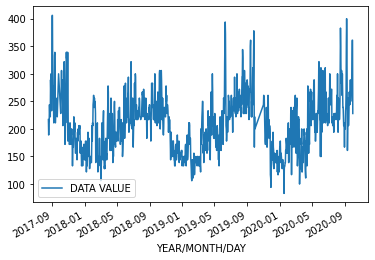

In [33]:
berkeley_time_series["TMAX"].tail(365 * 3).plot();

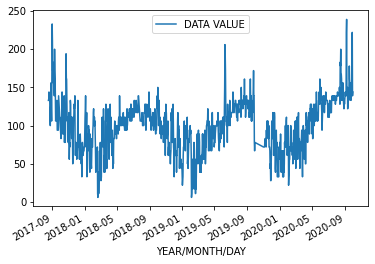

In [34]:
berkeley_time_series["TMIN"].tail(365 * 3).plot();

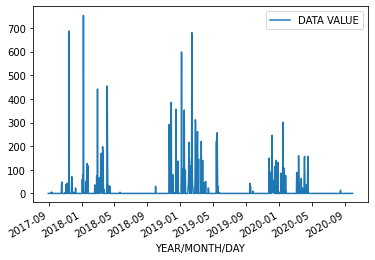

In [35]:
berkeley_time_series["PRCP"].tail(365 * 3).plot();

# Modeling

## Simple Modeling with FFT
Using NumPy's FFT module to forecast seasonal weather patterns by extrapolation. A function will be extrapolated with FFT on the training dataset and then we can evaluate how well we extrapolated using root mean squared error. We can also tune the variables such as `ratio`, `predict`, and `n_harm` which represents ratio between training and test set, number of days to predict in test set, and frequency of FFT respectively. Tuning these will help avoiding overfitting.

* Source: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce
* StackOverflow Post: https://stackoverflow.com/questions/4479463/using-fourier-analysis-for-time-series-prediction

In [36]:
def fourier_extrapolation(X, n_predict, n_harm=100):
    n = X.size
    t = np.arange(0, n)
    p = np.polyfit(t, X, 1)            # find linear trend in x
    X_notrend = X - p[0] * t           # detrended x
    X_freqdom = np.fft.fft(X_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(X_freqdom[i]) / n   # amplitude
        phase = np.angle(X_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

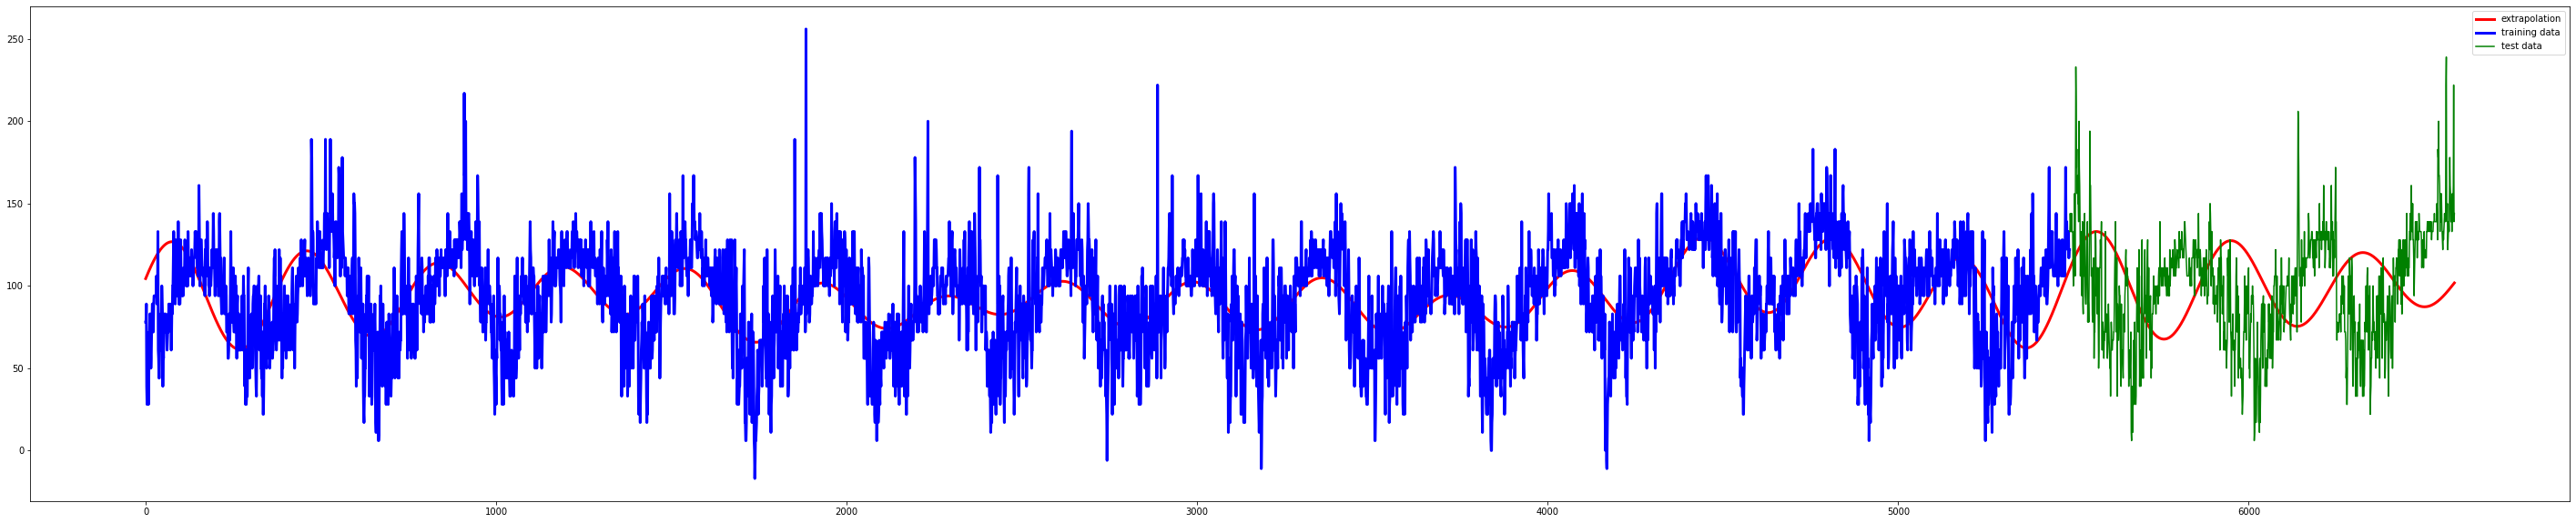

In [37]:
ratio = 6      # Ratio will be train:test = ratio:1
predict = 366 * 3 # Number of future days to predict
n_harm = 15

X_train = berkeley_time_series["TMIN"].sort_index().iloc[-ratio * predict:-predict].to_numpy().reshape(-1) 
X_test = berkeley_time_series["TMIN"].sort_index().iloc[-predict:].to_numpy().reshape(-1) 

extrapolation = fourier_extrapolation(X_train, predict, n_harm=n_harm)
plt.figure(figsize=(50, 10))
plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation', linewidth=3)
plt.plot(np.arange(0, X_train.size), X_train, 'b', label = r'training data', linewidth = 3)
plt.plot(np.arange(X_train.size, extrapolation.size), X_test, 'g', label = r'test data')
plt.legend()
plt.savefig("fft_berkeley_tmin.png")

In [38]:
print("Training RMSE:", rmse(extrapolation[:X_train.size], X_train))
print("Test RMSE:", rmse(extrapolation[-X_test.size:], X_test))

Training RMSE: 25.87679245280087
Test RMSE: 42.69312862202003


For more sporadic data like precipitation, it's much more harder to predict and identify trends with FFT, thus giving a large RMSE value compared to temperature.

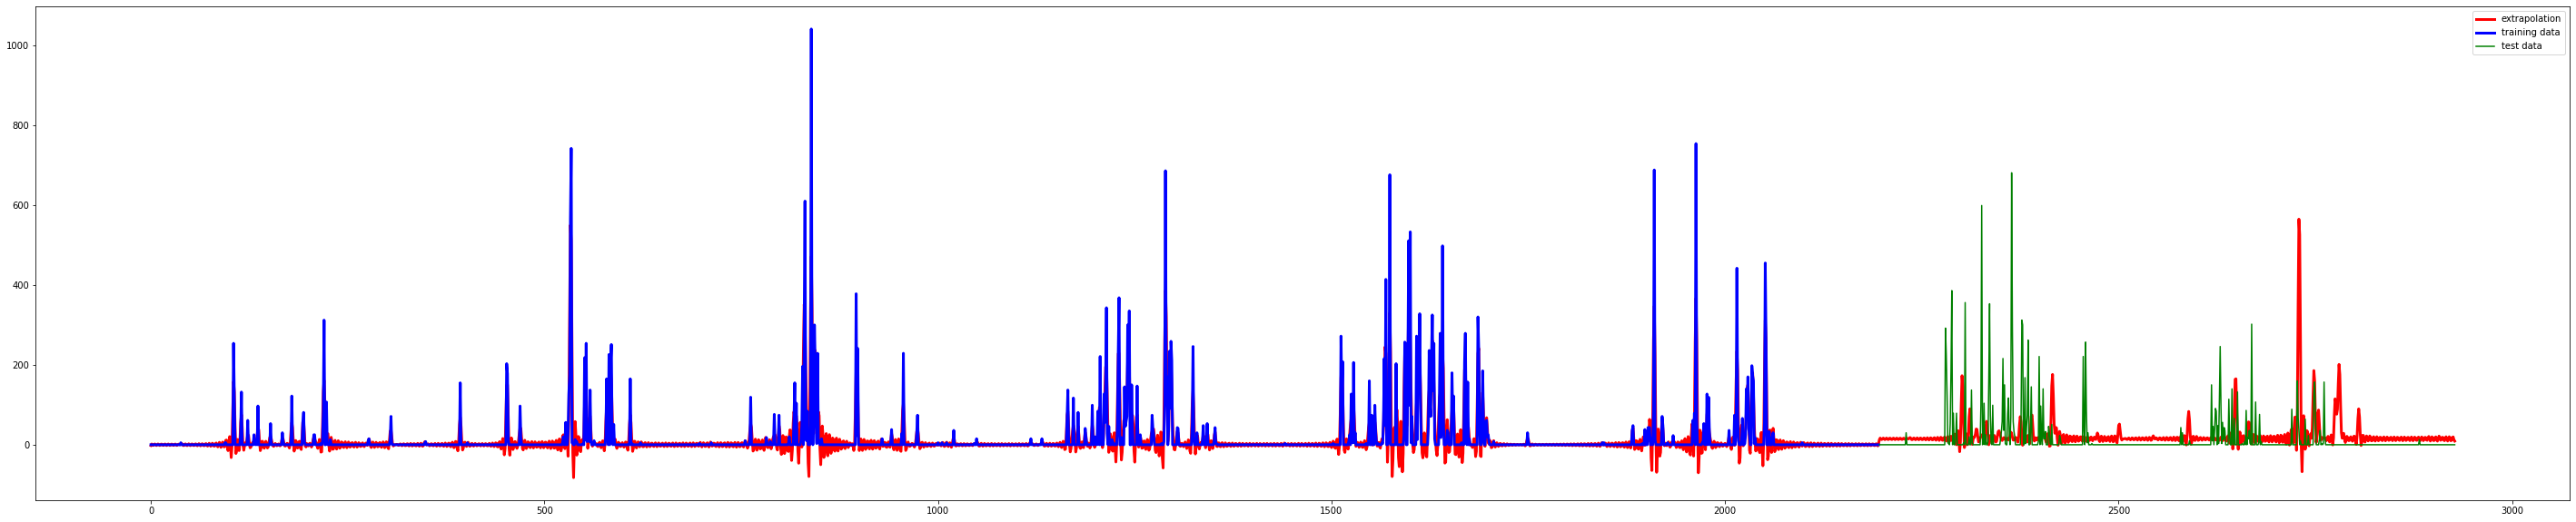

In [39]:
ratio = 4
predict = 366 * 2 # Number of future days to predict
n_harm = 500

X_train = berkeley_time_series["PRCP"].sort_index().iloc[-ratio * predict:-predict].to_numpy().reshape(-1) 
X_test = berkeley_time_series["PRCP"].sort_index().iloc[-predict:].to_numpy().reshape(-1) 

extrapolation = fourier_extrapolation(X_train, predict, n_harm=n_harm)
plt.figure(figsize=(50, 10))
plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation', linewidth=3)
plt.plot(np.arange(0, X_train.size), X_train, 'b', label = r'training data', linewidth = 3)
plt.plot(np.arange(X_train.size, extrapolation.size), X_test, 'g', label = r'test data')
plt.legend()
plt.savefig("fft_berkeley_prcp.png")

In [40]:
print("Training RMSE:", rmse(extrapolation[:X_train.size], X_train))
print("Test RMSE:", rmse(extrapolation[-X_test.size:], X_test))

Training RMSE: 40.66609084740897
Test RMSE: 69.87441163404335


## Linear Regression with NumS and Time Series Data

In [41]:
from nums.models.glms import LinearRegression

In [42]:
y_train = berkeley_time_series["TMIN"].iloc[-4000:-1000].to_numpy().reshape(-1) 
y_test = berkeley_time_series["TMIN"].iloc[-1000:].to_numpy().reshape(-1) 

#convert to NumS arrays, assigning to y since we want X to be time, y to be TMIN (data value)
y_train = nps.array(y_train)
y_test = nps.array(y_test)

Using driver node ip as head node.
head node 10.0.0.4
total cpus 32.0
device_grid (0, 0) 0=node:10.0.0.4/cpu:1


In [43]:
X_train = nps.arange(0, y_train.shape[0], 1).reshape(-1, 1).astype(np.double)
X_test = nps.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0], 1).reshape(-1, 1).astype(np.double)

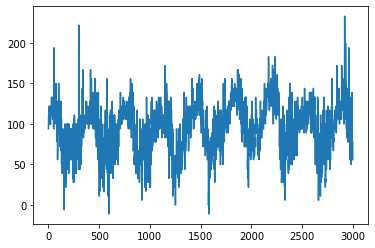

In [44]:
plt.plot(X_train.get(), y_train.get());

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Training RMSE:", rmse(y_train, model.predict(X_train)))
print("Test RMSE:", rmse(y_test, model.predict(X_test)))

Training RMSE: 30.536243170190698
Test RMSE: 33.47685636485453


We can also plot what the model predicts on the training set and test set.

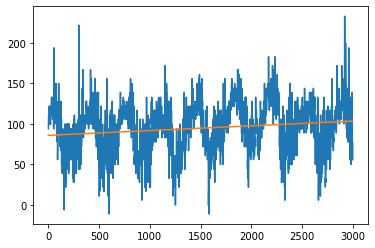

In [46]:
plt.plot(X_train.get(), y_train.get())
plt.plot(X_train.get(), model.predict(X_train).get());

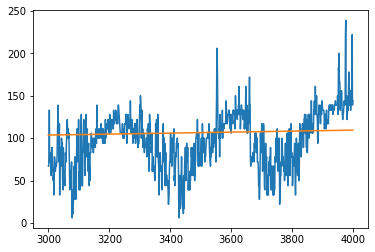

In [47]:
plt.plot(X_test.get(), y_test.get())
plt.plot(X_test.get(), model.predict(X_test).get());

Model also reveals to use that there is only a slight positive trend in data with the slope obtained from:

In [48]:
model._beta.get()

array([0.00586346])

## Creating the Design Matrix for Predicting/Classifying Precipitation
Next, we can create a design matrix with multiple features as elements and perform classification. In the next few cells, we will try to classify whether or not it will precipitate from data all around the world! We will use several features to help us determine if there is precipitation or not such as temperature, location, elevation, and day of the year. Note that what we are doing is *time-independent* opposed to the previous example with time series. We will explore various popular models in classical machine learning.

In [49]:
%%time
test_elements = ["PRCP", "TMAX", "TMIN"]
data = design_matrix(years[-10:], test_elements, target=["PRCP"], convert_nps=False, local=local)
data = data[data["PRCP"] >= 0]
data

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 55s, sys: 30.3 s, total: 3min 25s
Wall time: 8min 39s


,ID,YEAR/MONTH/DAY,PRCP,TMAX,TMIN,LATITUDE,LONGITUDE,ELEVATION,AVG,RANGE
3,AE000041196,4,0.0,24.5,15.8,25.3330,55.517,34.0,20.15,8.7
7,AE000041196,8,0.0,27.8,10.7,25.3330,55.517,34.0,19.25,17.1
8,AE000041196,9,0.0,29.1,10.4,25.3330,55.517,34.0,19.75,18.7
9,AE000041196,10,0.0,29.0,12.8,25.3330,55.517,34.0,20.90,16.2
12,AE000041196,13,0.0,30.6,16.0,25.3330,55.517,34.0,23.30,14.6
...,...,...,...,...,...,...,...,...,...,...
5697852,WQW00041606,105,0.0,27.7,22.9,19.2833,166.650,4.3,25.30,4.8
5697862,WQW00041606,125,0.0,30.3,24.4,19.2833,166.650,4.3,27.35,5.9
5697865,WQW00041606,128,0.0,29.6,23.7,19.2833,166.650,4.3,26.65,5.9
5697875,WQW00041606,159,0.0,27.6,24.5,19.2833,166.650,4.3,26.05,3.1


Going back to our EDA, we can visualize the design matrix through plotly by plotting the precipitaton during a certain day of the year. Here, we can plot the precipication on January 1st 2020. We observe that there is a lot of rain happening at higher elevations (mountains) in the US. There are also data at other places, but recalling our previous station density map, it's not as dense in other places.

http://127.0.0.1:8888/files/prcp_dmatrix_density.html

In [50]:
plot = design_matrix([2020], test_elements, target=["PRCP"], convert_nps=False, local=local)
plot = plot[plot["PRCP"] >= 0]
plot = plot[(plot["YEAR/MONTH/DAY"] == 1) & (plot["PRCP"] > 0)]
fig = go.Figure(go.Densitymapbox(lat=plot.LATITUDE, lon=plot.LONGITUDE, z=plot.PRCP,
                                 radius=10))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("prcp_dmatrix_density.html")

  0%|          | 0/1 [00:00<?, ?it/s]

Here, we will perform a train-test-split based on station IDs.

In [51]:
ids = np.random.permutation(data["ID"].unique())
split = int(ids.shape[0] * .8)
train_ids = ids[:split]
test_ids = ids[split:]

In [52]:
train = data[data["ID"].isin(train_ids)]
test = data[data["ID"].isin(test_ids)]
#'TMAX', 'TMIN','AVG', 'RANGE',
X_train = train[['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].to_numpy().astype(np.double)
y_train = train['PRCP'].to_numpy().astype(np.double)
X_test = test[['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].to_numpy().astype(np.double)
y_test = test['PRCP'].to_numpy().astype(np.double)

# NumS arrays must maintain block shapes, code below ensures they are shaped correctly.
X_train = nps.array(X_train)
y_train = nps.array(y_train)
X_test = nps.array(X_test)
y_test = nps.array(y_test)
y_train = y_train.reshape(block_shape=(X_train.block_shape[0],))
y_test = y_test.reshape(block_shape=(X_test.block_shape[0],))

## Linear Regression with NumS and Multiple Features
Next , we'll use linear regression with NumS to see if we can classify precipitation.

In [53]:
from nums.models.glms import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

In [54]:
training_results = model.predict(X_train).get()
test_results = model.predict(X_test).get()

print("Training RMSE:", rmse(training_results, y_train.get()))
print("Testing RMSE", rmse(test_results, y_test.get()))

Training RMSE: 2.574520995894019e+21
Testing RMSE 2.6032853832411303e+21


## Logistic Regression with NumS and Multiple Features
A continutation from the previous module, we can also use NumS logistic regression to classify if there is precipitation or not.

We can set y to be a binary variable, but we need to do some hacks since advanced indexing is not supported yet on NumS

In [55]:
# convert y_train and y_test to binary variable
y_train_block_shape = y_train.block_shape
y_train = y_train.get()
y_train[y_train > 0] = 1.0
y_train = nps.array(y_train)
y_train = y_train.reshape(block_shape=y_train_block_shape)


y_test_block_shape = y_test.block_shape
y_test = y_test.get()
y_test[y_test > 0] = 1.0
y_test = nps.array(y_test)
y_test = y_test.reshape(block_shape=y_test_block_shape)

In [56]:
from nums.models.glms import LogisticRegression

# since matrix could be singular, a mask is added on to X_train to help invert it
mask = nps.random.rand(X_train.shape[0], X_train.shape[1]) * 0.00001

model = LogisticRegression()
model.fit(X_train + mask, y_train)

In [57]:
training_results = model.predict(X_train).get()
test_results = model.predict(X_test).get()

print("Training Accuracy:", np.sum(training_results == y_train.get()) / y_train.shape[0])
print("Test Accuracy:", np.sum(test_results == y_test.get()) / y_test.shape[0])

Training Accuracy: 0.7118699228109835
Test Accuracy: 0.7103501077018286


## Decision Trees with Scikitlearn
We can also use Scikit-learn's Decision Tree to train and predict if there is precipitation or not. We can also use that model to plot out the features it splits on, giving us more insight on what the motivating features are. For the purposes of plotting, the depth is limited to 3.

In [58]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train.get(), y_train.get())

DecisionTreeClassifier(max_depth=3)

In [59]:
print("Training Accuracy:", model.score(X_train.get(), y_train.get()))
print("Test Accuracy:", model.score(X_test.get(), y_test.get()))

Training Accuracy: 0.7088413711020969
Test Accuracy: 0.7078100233825783


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=4.362537839933951.
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoS

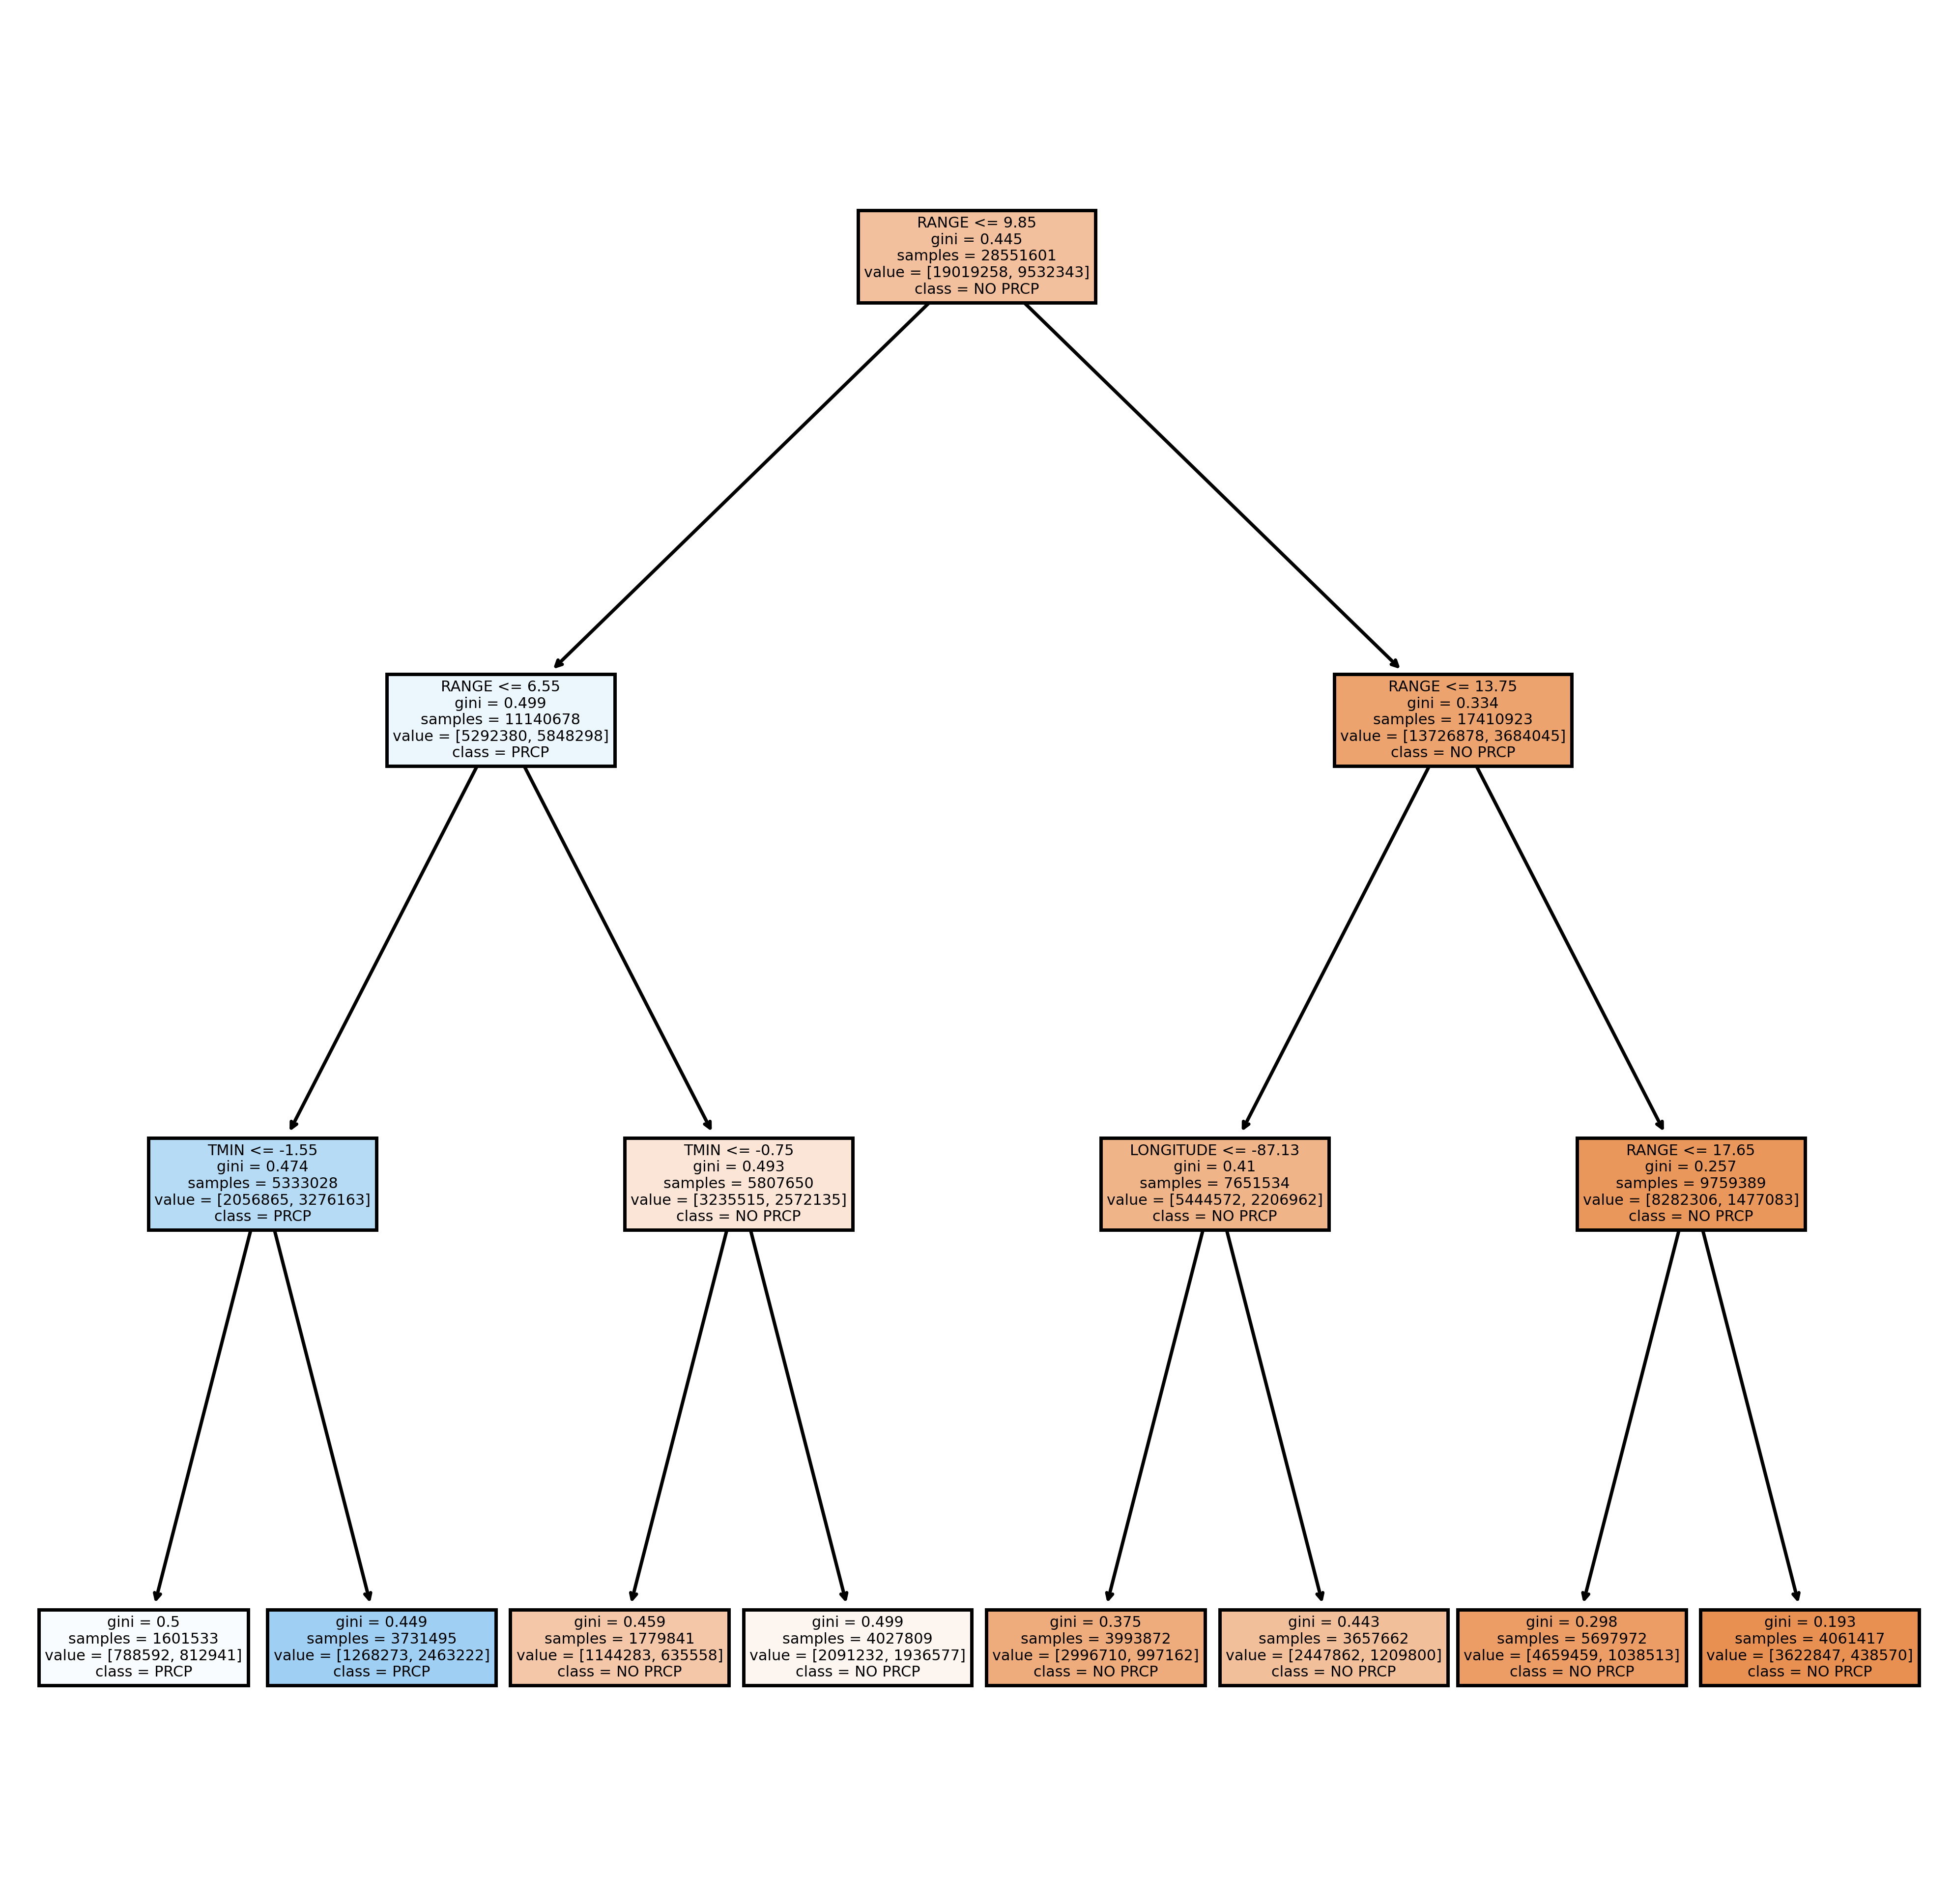

In [60]:
columns = ['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=500);

tree.plot_tree(model, feature_names=columns, class_names=["NO PRCP", "PRCP"], filled=True);

fig.savefig('decision_tree_prcp.png', dpi=500, transparent=False)

## XGBoost with Modin (Experimental)
We can also perform classification with XGBoost within the expermeintal package in Modin.

* Documentation: https://modin.readthedocs.io/en/latest/modin_xgboost.html

In [61]:
import modin.experimental.xgboost as xgb

In [62]:
dtrain = xgb.DMatrix(pd.DataFrame(X_train.get()), pd.DataFrame(y_train.get()))
dtest = xgb.DMatrix(pd.DataFrame(X_test.get()), pd.DataFrame(y_test.get()))

In [63]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 3,
    "objective": "multi:softprob",
    "num_class": 2,
    "eval_metric": "mlogloss",
}
steps = 20

# Create dict for evaluation results
evals_result = dict()

# Run training
model = xgb.train(
    xgb_params,
    dtrain,
    steps,
    evals=[(dtrain, "train")],
    evals_result=evals_result
)

# Print evaluation results
print(f'Evals results:\n{evals_result}')

# Predict results
prediction = model.predict(dtest)

# Print prediction results
print(f'Prediction results:\n{prediction}')

Training started
Data preparation time: 0.671334981918335 s
start listen on 10.0.0.4:9091
Received start signal from 10.0.0.4; assign rank 0
Received start signal from 10.0.0.4; assign rank 1
Received start signal from 10.0.0.4; assign rank 2
Received start signal from 10.0.0.4; assign rank 3
Received start signal from 10.0.0.4; assign rank 4
Received start signal from 10.0.0.4; assign rank 5
Received start signal from 10.0.0.4; assign rank 6
Received start signal from 10.0.0.4; assign rank 7
Received start signal from 10.0.0.4; assign rank 8
Received start signal from 10.0.0.4; assign rank 9
Received start signal from 10.0.0.4; assign rank 10
Received start signal from 10.0.0.4; assign rank 11
Received start signal from 10.0.0.4; assign rank 12
Received start signal from 10.0.0.4; assign rank 13
Received start signal from 10.0.0.4; assign rank 14
Received start signal from 10.0.0.4; assign rank 15
@tracker All of 16 nodes getting started
(pid=37268) [00:08:20] task [modin.xgboost]:3 g

In [64]:
y_result = prediction[1].to_numpy()
y_result[y_result >= 0.5] = 1
y_result[y_result < 0.5] = 0
np.sum(y_result == y_test.get()) / y_result.shape[0]

0.7229479963685315

## Random Forests with Ray Backend
We can also perform random forest classifier with Ray by replacing the parallel backend joblib with Ray. This will automatically distribute Decision Trees across multiple threads/clusters.

In [65]:
from sklearn.ensemble import RandomForestClassifier
import joblib
from ray.util.joblib import register_ray
register_ray()

with joblib.parallel_backend('ray'):
    model = RandomForestClassifier(n_jobs=n_jobs)
model.fit(X_train.get(), y_train.get())

RandomForestClassifier(n_jobs=32)

In [66]:
print("Training Accuracy:", model.score(X_train.get(), y_train.get()))
print("Test Accuracy:", model.score(X_test.get(), y_test.get()))

Training Accuracy: 0.9983556788987069
Test Accuracy: 0.7556805073915257


## Using Models to Learn New Locations
Using a model, can we possibly "learn" a new location that doesn't have a weather station? We can create a meshgrid of longitude and latitude, just by location, to attempt to clasify precipitation. Of course, we have to discard features like temperature. We also have to discard elevation, but if there happens to be detailed terrain data for longitude, latitude, and elevation, it could definitely help. 

In [67]:
x = np.linspace(-90, 90, 1000)
y = np.linspace(-180, 180, 1000)

geo_data = []

for i in tqdm(range(x.shape[0])):
    for j in range(y.shape[0]):
        geo_data.append((x[i], y[j]))
        
new_location_df = pd.DataFrame(geo_data, columns=["lat", "lon"])
new_location_df["day"] = 1
new_location_df = new_location_df.reindex(columns=['day', 'lat', 'lon'])
location_grid = new_location_df.to_numpy().astype(np.double)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [68]:
test_elements = ["PRCP", "TMAX", "TMIN"]
data = design_matrix(years[-1:], test_elements, target=["PRCP"], convert_nps=False, local=local)
data = data[data["PRCP"] >= 0]
df = data[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE", "PRCP"]]
df = df[df["YEAR/MONTH/DAY"] == 1]
X = df[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE"]].to_numpy()
y = df["PRCP"].to_numpy()
y[y > 0] = 1

  0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
with joblib.parallel_backend('ray'):
    model = RandomForestClassifier(n_jobs=n_jobs)
model.fit(X, y)
print("Training Accuracy:", model.score(X, y))

Training Accuracy: 0.9986304496690254


In [70]:
# Predict new locations
prcp = model.predict(location_grid)
new_location_df["prcp"] = prcp
new_location_df = new_location_df[new_location_df["prcp"] == 1]
new_location_df

,day,lat,lon,prcp
69,1,-90.0,-155.135135,1.0
70,1,-90.0,-154.774775,1.0
71,1,-90.0,-154.414414,1.0
72,1,-90.0,-154.054054,1.0
73,1,-90.0,-153.693694,1.0
...,...,...,...,...
999995,1,90.0,178.558559,1.0
999996,1,90.0,178.918919,1.0
999997,1,90.0,179.279279,1.0
999998,1,90.0,179.639640,1.0


In [71]:
fig = go.Figure(go.Densitymapbox(lon=new_location_df.lon, lat=new_location_df.lat, radius=5))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("new_locations_prcp.html")

In [72]:
actual = data[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE", "PRCP"]]
actual = actual[(actual["YEAR/MONTH/DAY"] == 1) & (actual["PRCP"] > 0)]
actual

,YEAR/MONTH/DAY,LATITUDE,LONGITUDE,PRCP
13828,1,-14.3306,-170.7136,53.0
27664,1,-53.7780,-67.7490,3.0
28040,1,-16.2880,149.9650,81.0
29262,1,-14.2964,126.6453,312.0
35064,1,-18.6844,121.7803,62.0
...,...,...,...,...
5682870,1,62.7369,-141.2083,6.0
5695636,1,17.7028,-64.8056,13.0
5695829,1,18.3331,-64.9667,3.0
5696198,1,-22.5670,17.1000,71.0


In [73]:
fig = go.Figure(go.Densitymapbox(lon=actual.LONGITUDE, lat=actual.LATITUDE,
                                 radius=5))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("actual_prcp.html")

## Modeling (Again but with Classifying Snow)
Next, we will repeat the same models but with snow. But as we see when we graph it, we are limited to only US and Canada data, as other countries don't support snow data.

In [74]:
%%time
test_elements = ["SNOW", "TMAX", "TMIN"]
data = design_matrix(years[-10:], test_elements, target=["SNOW"], convert_nps=False, local=local)
data = data[data["SNOW"] >= 0]
data

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 1s, sys: 15.8 s, total: 2min 16s
Wall time: 6min 7s


,ID,YEAR/MONTH/DAY,SNOW,TMAX,TMIN,LATITUDE,LONGITUDE,ELEVATION,AVG,RANGE
353489,CA001011500,1,2.0,7.5,1.5,48.9333,-123.7500,75.0,4.50,6.0
353490,CA001011500,2,0.0,8.5,3.0,48.9333,-123.7500,75.0,5.75,5.5
353491,CA001011500,3,0.0,8.5,5.5,48.9333,-123.7500,75.0,7.00,3.0
353492,CA001011500,4,0.0,10.5,7.5,48.9333,-123.7500,75.0,9.00,3.0
353493,CA001011500,5,0.0,8.0,4.5,48.9333,-123.7500,75.0,6.25,3.5
...,...,...,...,...,...,...,...,...,...,...
4029182,VQW00011640,175,0.0,32.2,26.7,18.3331,-64.9667,6.1,29.45,5.5
4029186,VQW00011640,179,0.0,30.6,26.1,18.3331,-64.9667,6.1,28.35,4.5
4029187,VQW00011640,180,0.0,31.7,26.1,18.3331,-64.9667,6.1,28.90,5.6
4029192,VQW00011640,185,0.0,32.8,26.7,18.3331,-64.9667,6.1,29.75,6.1


As mentioned before, we can plot the data, and graph it onto a map to see that Snow data is only available on US and Canada

http://127.0.0.1:8888/files/snow_dmatrix_density.html

And for comparison, we see that not all precipation data is snow. An interesting observation is that sometimes snow in mountain happens at higher elevations:

http://127.0.0.1:8888/files/prcp_dmatrix_density.html

In [75]:
plot = design_matrix([2020], test_elements, target=["SNOW"], convert_nps=False, local=local)
plot = plot[plot["SNOW"] >= 0]
plot = plot[(plot["YEAR/MONTH/DAY"] == 1) & (plot["SNOW"] > 0)]
fig = go.Figure(go.Densitymapbox(lat=plot.LATITUDE, lon=plot.LONGITUDE, z=plot.SNOW,
                                 radius=10))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("snow_dmatrix_density.html")

  0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
ids = np.random.permutation(data["ID"].unique())
split = int(ids.shape[0] * .8)
train_ids = ids[:split]
test_ids = ids[split:]

In [77]:
train = data[data["ID"].isin(train_ids)]
test = data[data["ID"].isin(test_ids)]
#'TMAX', 'TMIN','AVG', 'RANGE',
X_train = train[['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].to_numpy().astype(np.double)
y_train = train['SNOW'].to_numpy().astype(np.double)
X_test = test[['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].to_numpy().astype(np.double)
y_test = test['SNOW'].to_numpy().astype(np.double)

# NumS arrays must maintain block shapes, code below ensures they are shaped correctly.
X_train = nps.array(X_train)
y_train = nps.array(y_train)
X_test = nps.array(X_test)
y_test = nps.array(y_test)
y_train = y_train.reshape(block_shape=(X_train.block_shape[0],))
y_test = y_test.reshape(block_shape=(X_test.block_shape[0],))

## Linear Regression with Multiple Features (Snow)

In [78]:
model = LinearRegression()
model.fit(X_train, y_train)

In [79]:
training_results = model.predict(X_train).get()
test_results = model.predict(X_test).get()

print("Training RMSE:", rmse(training_results, y_train.get()))
print("Testing RMSE", rmse(test_results, y_test.get()))

Training RMSE: 18.437872376751088
Testing RMSE 17.49126773974197


## Logistic Regression with Multiple Features (Snow)

In [80]:
# convert y_train and y_test to binary variable
y_train_block_shape = y_train.block_shape
y_train = y_train.get()
y_train[y_train > 0] = 1.0
y_train = nps.array(y_train)
y_train = y_train.reshape(block_shape=y_train_block_shape)


y_test_block_shape = y_test.block_shape
y_test = y_test.get()
y_test[y_test > 0] = 1.0
y_test = nps.array(y_test)
y_test = y_test.reshape(block_shape=y_test_block_shape)

In [81]:
# since matrix could be singular, a mask is added on to X_train to help invert it
mask = nps.random.rand(X_train.shape[0], X_train.shape[1]) * 0.00001

model = LogisticRegression()
model.fit(X_train + mask, y_train)

In [82]:
training_results = model.predict(X_train).get()
test_results = model.predict(X_test).get()

print("Training Accuracy:", np.sum(training_results == y_train.get()) / y_train.shape[0])
print("Test Accuracy:", np.sum(test_results == y_test.get()) / y_test.shape[0])

Training Accuracy: 0.9299088352897298
Test Accuracy: 0.9332098523731216


## Decision Trees with Scikitlearn (Snow)

In [83]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train.get(), y_train.get())

DecisionTreeClassifier(max_depth=4)

In [84]:
print("Training Accuracy:", model.score(X_train.get(), y_train.get()))
print("Test Accuracy:", model.score(X_test.get(), y_test.get()))

Training Accuracy: 0.9355740058802087
Test Accuracy: 0.9379470741338708


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=2.3701916542068777.
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwo

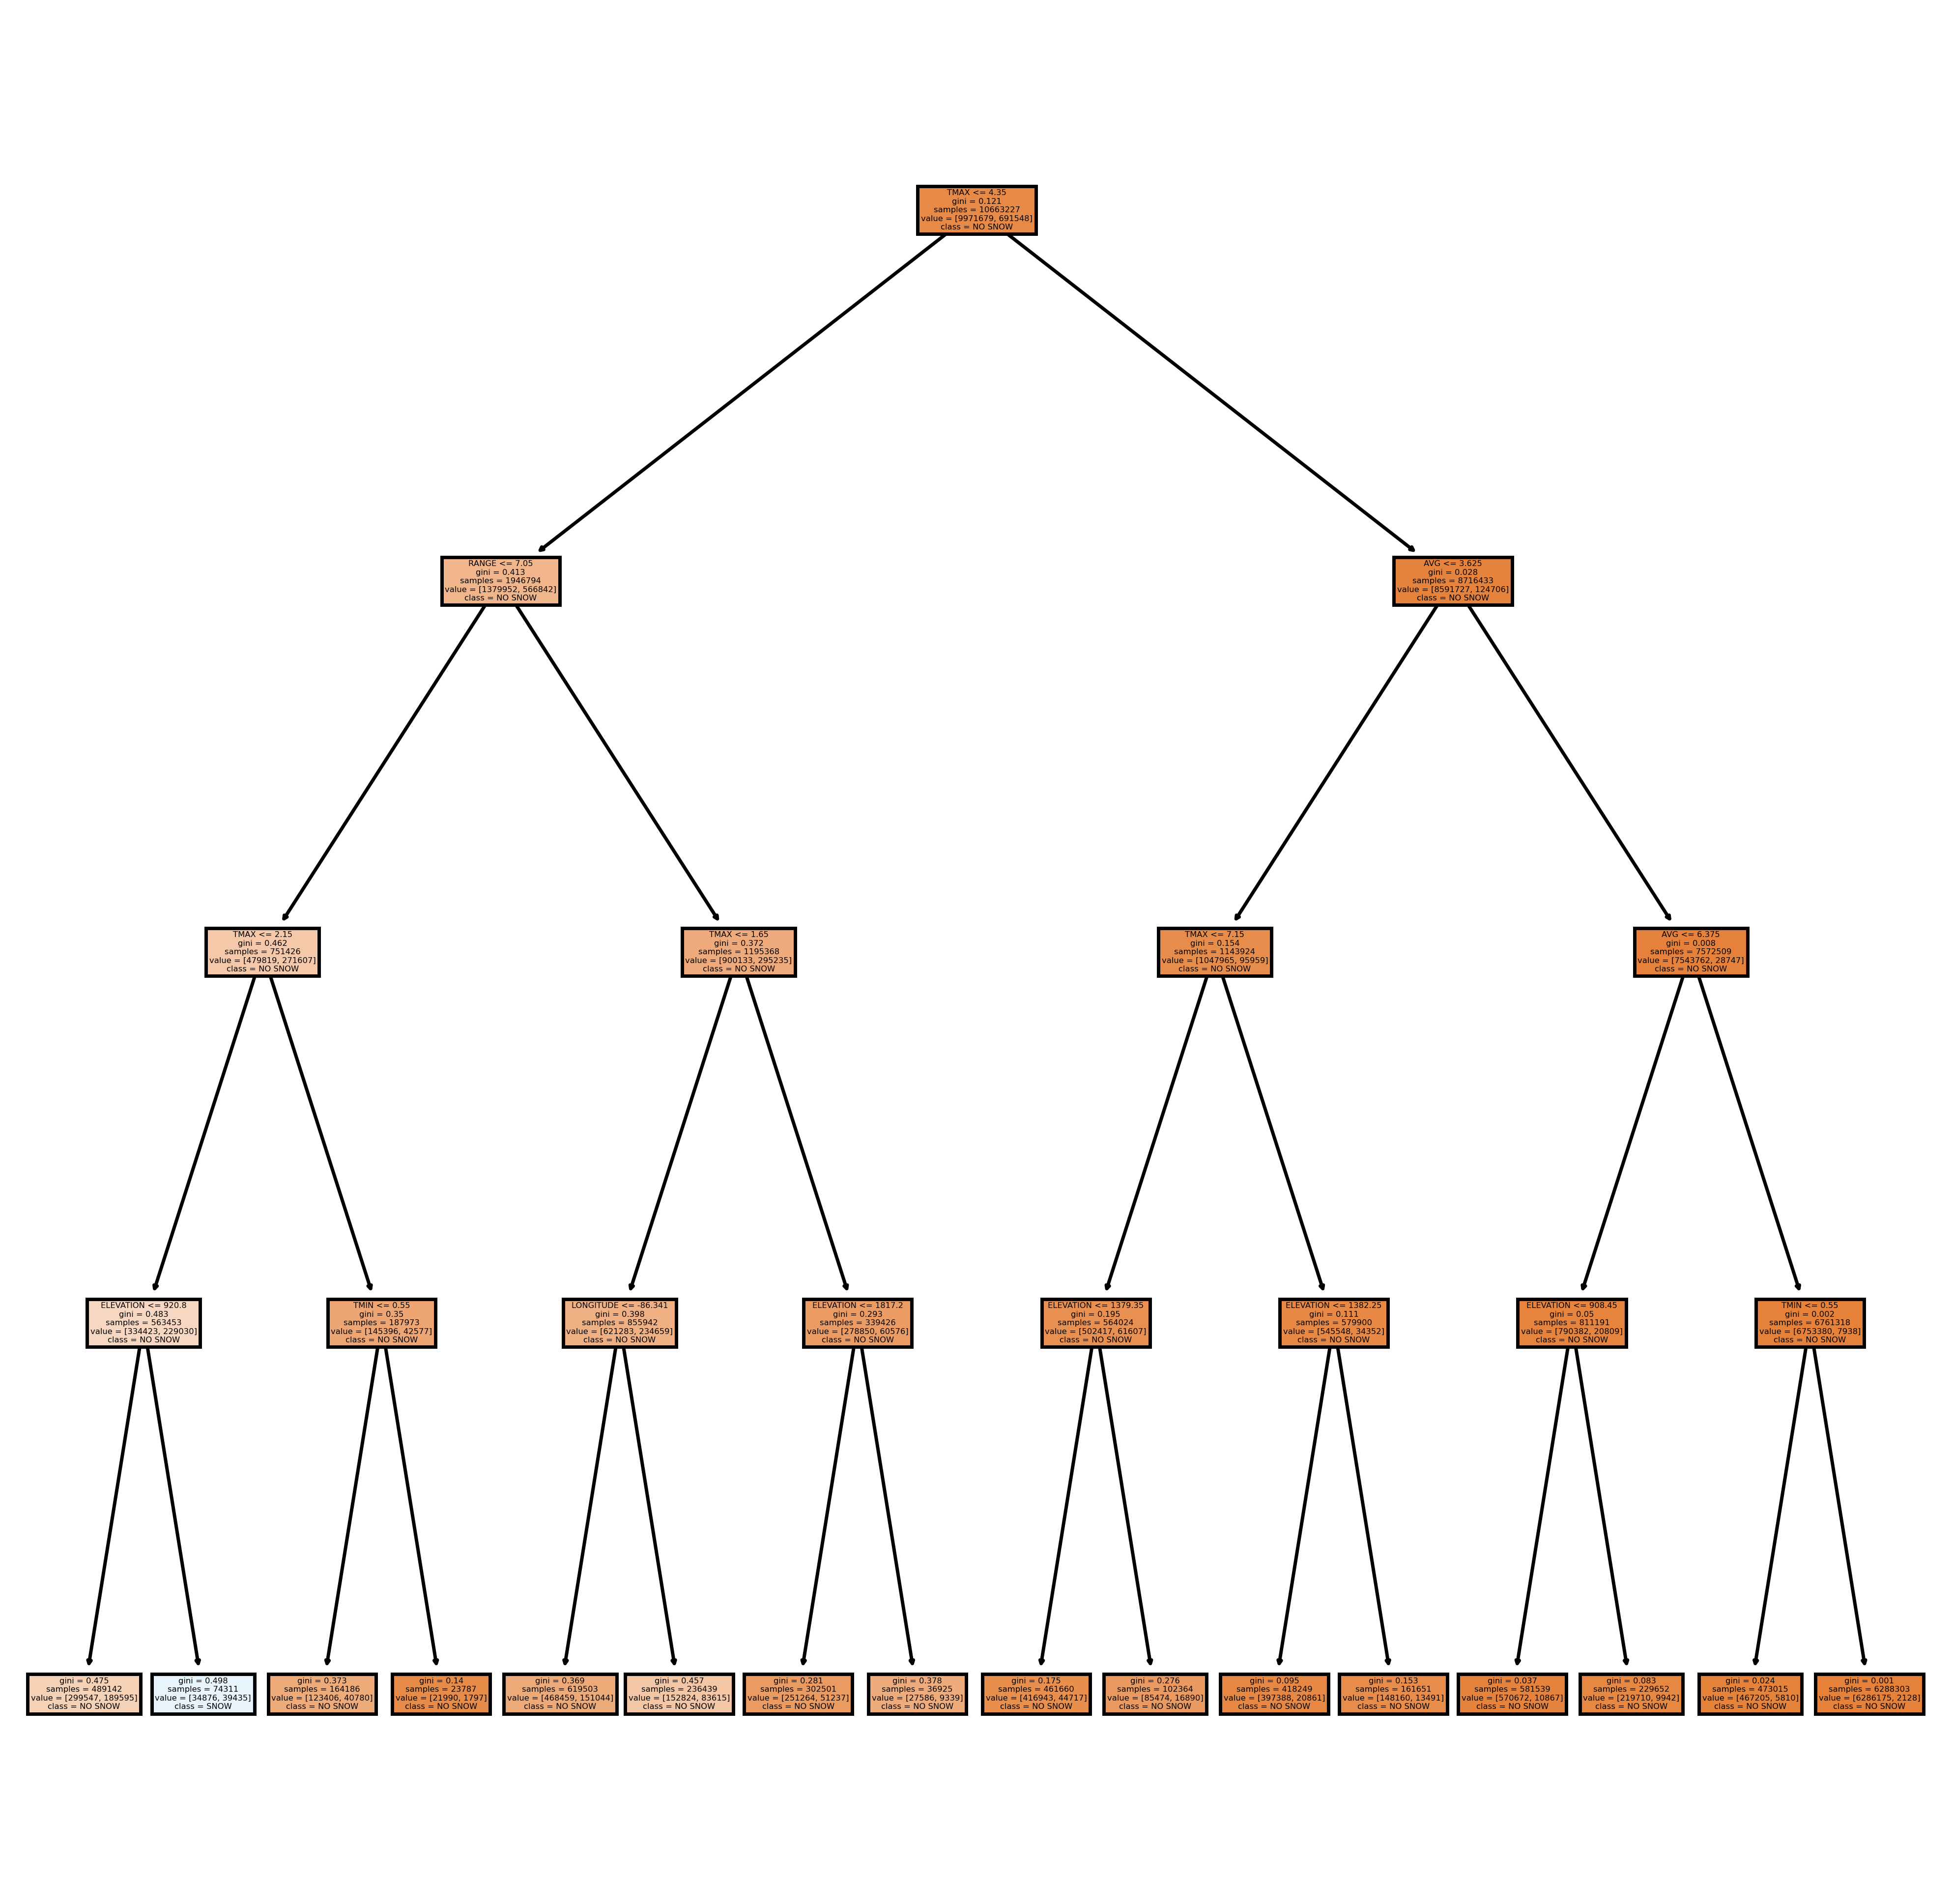

In [85]:
columns = ['YEAR/MONTH/DAY', 'TMAX', 'TMIN','AVG', 'RANGE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=500);

tree.plot_tree(model, feature_names=columns, class_names=["NO SNOW", "SNOW"], filled=True);

fig.savefig('decision_tree_snow.png', dpi=500, transparent=False)

## XGBoost with Modin (Snow)

In [86]:
dtrain = xgb.DMatrix(pd.DataFrame(X_train.get()), pd.DataFrame(y_train.get()))
dtest = xgb.DMatrix(pd.DataFrame(X_test.get()), pd.DataFrame(y_test.get()))

In [87]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 3,
    "objective": "multi:softprob",
    "num_class": 2,
    "eval_metric": "mlogloss",
}
steps = 20

# Create dict for evaluation results
evals_result = dict()

# Run training
model = xgb.train(
    xgb_params,
    dtrain,
    steps,
    evals=[(dtrain, "train")],
    evals_result=evals_result
)

# Print evaluation results
print(f'Evals results:\n{evals_result}')

# Predict results
prediction = model.predict(dtest)

# Print prediction results
print(f'Prediction results:\n{prediction}')

Training started
Data preparation time: 0.9636926651000977 s
start listen on 10.0.0.4:9091
Received start signal from 10.0.0.4; assign rank 0
Received start signal from 10.0.0.4; assign rank 1
Received start signal from 10.0.0.4; assign rank 2
Received start signal from 10.0.0.4; assign rank 3
Received start signal from 10.0.0.4; assign rank 4
Received start signal from 10.0.0.4; assign rank 5
Received start signal from 10.0.0.4; assign rank 6
Received start signal from 10.0.0.4; assign rank 7
Received start signal from 10.0.0.4; assign rank 8
Received start signal from 10.0.0.4; assign rank 9
Received start signal from 10.0.0.4; assign rank 10
Received start signal from 10.0.0.4; assign rank 11
Received start signal from 10.0.0.4; assign rank 12
Received start signal from 10.0.0.4; assign rank 13
Received start signal from 10.0.0.4; assign rank 14
Received start signal from 10.0.0.4; assign rank 15
@tracker All of 16 nodes getting started
(pid=24636) [00:26:52] task [modin.xgboost]:5 

In [88]:
y_result = prediction[1].to_numpy()
y_result[y_result >= 0.5] = 1
y_result[y_result < 0.5] = 0
np.sum(y_result == y_test.get()) / y_result.shape[0]

0.9382588960008564

In [89]:
with joblib.parallel_backend('ray'):
    model = RandomForestClassifier(n_jobs=n_jobs) #TODO, change n_jobs to match the number of threads in cluster
model.fit(X_train.get(), y_train.get())

RandomForestClassifier(n_jobs=32)

In [90]:
print("Training Accuracy:", model.score(X_train.get(), y_train.get()))
print("Test Accuracy:", model.score(X_test.get(), y_test.get()))

Training Accuracy: 0.9996691433090564
Test Accuracy: 0.9449089745926944


## Using Models to Learn New Locations (Snow)
This time, we'll predict new locations but only limited to US and Canada as other countries don't support snow data.

In [91]:
x = np.linspace(24.08032155421445, 57.34802037373902, 1000)
y = np.linspace(-127.16821237906673, -55.12130116091293, 1000)

geo_data = []

for i in tqdm(range(x.shape[0])):
    for j in range(y.shape[0]):
        geo_data.append((x[i], y[j]))
        
new_location_df = pd.DataFrame(geo_data, columns=["lat", "lon"])
new_location_df["day"] = 1
new_location_df = new_location_df.reindex(columns=['day', 'lat', 'lon'])
location_grid = new_location_df.to_numpy().astype(np.double)

  0%|          | 0/1000 [00:00<?, ?it/s]

For this, we will only predict snow at unknown locations on Januaury 1st, 2021.

In [92]:
test_elements = ["SNOW", "TMAX", "TMIN"]
data = design_matrix(years[-1:], test_elements, target=["SNOW"], convert_nps=False, local=local)
data = data[data["SNOW"] >= 0]
df = data[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE", "SNOW"]]
df = df[df["YEAR/MONTH/DAY"] == 1]
X = df[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE"]].to_numpy()
y = df["SNOW"].to_numpy()
y[y > 0] = 1

  0%|          | 0/1 [00:00<?, ?it/s]

In [93]:
with joblib.parallel_backend('ray'):
    model = RandomForestClassifier(n_jobs=n_jobs)
model.fit(X, y)
print("Training Accuracy:", model.score(X, y))

Training Accuracy: 0.9997321906802357


In [94]:
# Predict new locations
snow = model.predict(location_grid)
new_location_df["snow"] = snow
new_location_df = new_location_df[new_location_df["snow"] == 1]
new_location_df

,day,lat,lon,snow
157332,1,29.308579,-103.224694,1.0
157333,1,29.308579,-103.152575,1.0
157334,1,29.308579,-103.080456,1.0
165333,1,29.574987,-103.152575,1.0
166333,1,29.608288,-103.152575,1.0
...,...,...,...,...
999966,1,57.348020,-57.501229,1.0
999967,1,57.348020,-57.429110,1.0
999968,1,57.348020,-57.356991,1.0
999969,1,57.348020,-57.284872,1.0


For plotting purposes, we can just filter out where it snows. It'll be obvious in the plot where we set the boundaries.

In [95]:
fig = go.Figure(go.Densitymapbox(lon=new_location_df.lon, lat=new_location_df.lat, radius=5))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("new_locations_snow.html")

In [96]:
actual = data[["YEAR/MONTH/DAY", "LATITUDE", "LONGITUDE", "SNOW"]]
actual = actual[(actual["YEAR/MONTH/DAY"] == 1) & (actual["SNOW"] > 0)]
actual

,YEAR/MONTH/DAY,LATITUDE,LONGITUDE,SNOW
178121,1,50.1333,-122.9500,104.0
181432,1,53.5667,-127.9500,30.0
181626,1,54.0500,-128.6333,500.0
181814,1,54.0167,-128.7000,150.0
182678,1,54.5000,-128.6167,120.0
...,...,...,...,...
4010298,1,42.2314,-83.3308,3.0
4010492,1,45.0717,-83.5644,3.0
4011069,1,42.8939,-85.5447,25.0
4012805,1,42.3978,-90.7036,18.0


In [97]:
fig = go.Figure(go.Densitymapbox(lon=actual.LONGITUDE, lat=actual.LATITUDE,
                                 radius=5))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("actual_snow.html")

## PCA with NumS
We can stack years of data on top of each other to give a design matrix of years as cols/features, and day of the year as rows/data point. Running PCA can tell us if there is any abnormality weather between the years. Continuing with the data from Berkeley, this is what the data shows:

Source/inspriation: https://towardsdatascience.com/the-pca-trick-with-time-series-d40d48c69d28

In [98]:
berkeley_tmax_design_matrix = design_matrix_time_series_stack('USC00040693', 'TMAX', years, local=local)

  0%|          | 0/259 [00:00<?, ?it/s]

TMAX data on 1763 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1764 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1765 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1766 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1767 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1768 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1769 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1770 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1771 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
TMAX data on 1772 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.


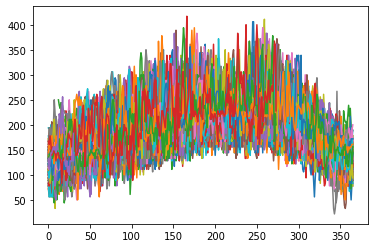

In [99]:
for i in range(berkeley_tmax_design_matrix.shape[0]):
    plt.plot(berkeley_tmax_design_matrix[i].get());

Seems like the data has one significant feature, which should be expected. Also notice a jump near day 50, indicating that this is around February, when leap days occur, causing inconsistencies in data. There are also some abnormalities in the other dimensions, potentially indicating shifts/differences in climate change.

In [100]:
%%time
U, S, V = np.linalg.svd(np.nan_to_num(berkeley_tmax_design_matrix.T.get()), full_matrices=False)

CPU times: user 5.69 ms, sys: 4 ms, total: 9.69 ms
Wall time: 8.36 ms


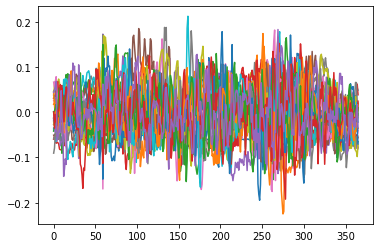

In [101]:
for i in range(25):
    plt.plot(U.T[i, :])

In [102]:
from nums.core import linalg
from nums.core import application_manager
nps_app_inst = application_manager.instance()

In [103]:
%%time
U, S, V = linalg.svd(nps_app_inst, nps.nan_to_num(berkeley_tmax_design_matrix.T))
U.touch() #for timing purposes
S.touch()
V.touch()

CPU times: user 26.3 ms, sys: 561 µs, total: 26.8 ms
Wall time: 35.1 ms


BlockArray([[Block(ObjectRef(c69fd8961e0ac566ffffffffffffffffffffffff0100000003000000))]])

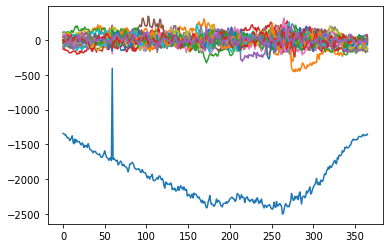

In [104]:
for i in range(25):
    plt.plot((U.T[i, :] * S[i]).get());

Scree Plot of the first 10 singular values

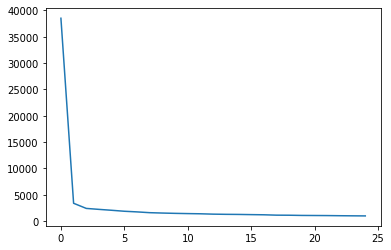

In [105]:
plt.plot(S[:25].get())

A spike near day 50 may indicate a gap in data when we have leap days/years.

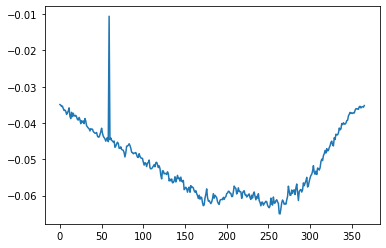

In [106]:
plt.plot(U.T[0, :].get());

Let's repeat the same with precipication data:

In [107]:
berkeley_prcp_design_matrix = design_matrix_time_series_stack('USC00040693', 'PRCP', years, local=local)

  0%|          | 0/259 [00:00<?, ?it/s]

PRCP data on 1763 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1764 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1765 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1766 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1767 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1768 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1769 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1770 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1771 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.
PRCP data on 1772 for BERKELEY with id: USC00040693 is empty. Addition to design matrix is skipped.


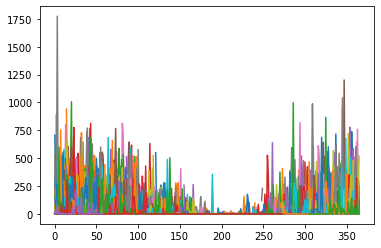

In [108]:
for i in range(berkeley_prcp_design_matrix.shape[0]):
    plt.plot(berkeley_prcp_design_matrix[i].get());

In [109]:
U, S, V = linalg.svd(nps_app_inst, nps.nan_to_num(berkeley_prcp_design_matrix.T))

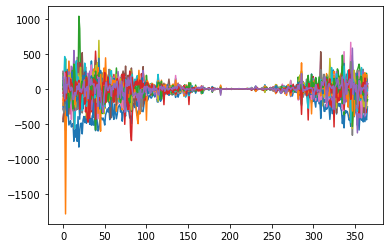

In [110]:
for i in range(25):
    plt.plot((U.T[i, :] * S[i]).get());

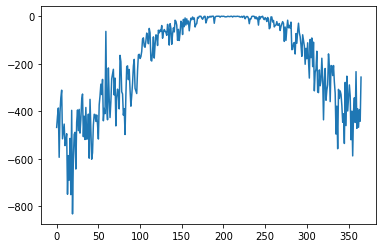

In [111]:
plt.plot((U.T[0, :] * S[0]).get());

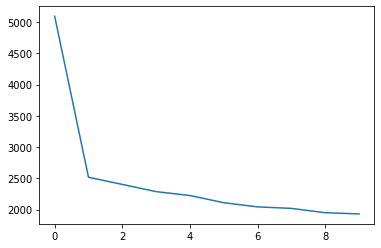

In [112]:
#scree plot
plt.plot(S[:10].get());

# End Here
When done, run this so you can delete the large dictionary of dataframes and shutdown Ray properly to free all processes.

In [113]:
del dfs

In [114]:
ray.shutdown()